# Extra transformers

Add custom transformers that are not implemented in `nebula`.

In [1]:
import yaml

from nebula.spark_transformers import *
from nebula.base import Transformer
from nebula.pipelines.pipelines import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline
from nebula.storage import nebula_storage as ns

## Create a pipeline with custom transformers using python

Three custom transformers:

- `Custom_1`: does not inherit the base transformer class `Transformer` from nebula.
- `Custom_2`: inherits the base transformer class `Transformer` from nebula.
- `Custom_3`: like Custom_1 but implemented in `custom_transformers.py`

There are 2 main differences when importing the base transformer class `Transformer` from `nebula`.
1. The method `_transform` must be private instead of public
2. The initialization parameters are displayed and logged

Inheriting the base class `Transformer` is strongly encouraged.

In [2]:
class Custom_1:
    def __init__(self, *, a):
        self._a = a
    
    def transform(self, df):  # public
        print("custom 1")
        return df


class Custom_2(Transformer):  # from nebula.base import Transformer
    def __init__(self, *, a):
        super().__init__()
        self._a = a
    
    def _transform(self, df):  # private
        print("custom 3")
        return df

import custom_transformers
    

pipe = TransformerPipeline([
    Custom_1(a=1),  # 'a' will not be displayed
    Custom_2(a=3),
    custom_transformers.Custom_3(),
])

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline *** (3 transformers)
 - Custom_1
 - Custom_2 -> PARAMS: a=3
 - Custom_3


## Pass custom transformers in YAML

To pass custom transformers when the YAML approach is used, they must be injected in `nebula` using the keyword argument `extra_transformers` in `load_pipeline`.

They must be passed as `list` of objects like `modules` (ie: `from my_library import my_custom_transformers`) or as objects that have the `getattr` method

Using modules instead of classes is encouraged.

They must be provided as `list` since their order determines the priority, with the first element holding higher priority than the last one.

For example, consider two modules, `module_x.py` and `module_y.py`, both featuring the transformer `Transformer_A` but implemented differently.
if `module_x.py` precedes `module_y.py` (`extra_transformers=[module_x, module_y]`) `module_x.Transformer_A` takes precedence and overwrites `module_y.Transformer_A`.

In [3]:
yml_data = """
pipeline:
  - transformer: Custom_1
    params: {"a": 1}
  - transformer: Custom_2
    params: {"a": 3}
  - transformer: Custom_3  # in custom_transformer.py
"""

class MyCustomModule:  # vanilla class that inherently has `getattr` method
    Custom_1=Custom_1
    Custom_2=Custom_2

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(
    pipe_cfg, 
    extra_transformers=[
        custom_transformers, 
        MyCustomModule
    ]  # Add here your list of transformer modules / classes with "getattr" method
)

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline *** (3 transformers)
 - Custom_1
 - Custom_2 -> PARAMS: a=3
 - Custom_3


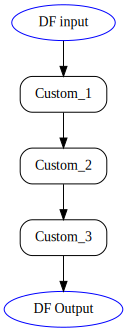

In [4]:
pipe.plot_dag()